In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station =  Base.classes.station 
measurement = Base.classes.measurement 

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

Query Date:  2016-08-23


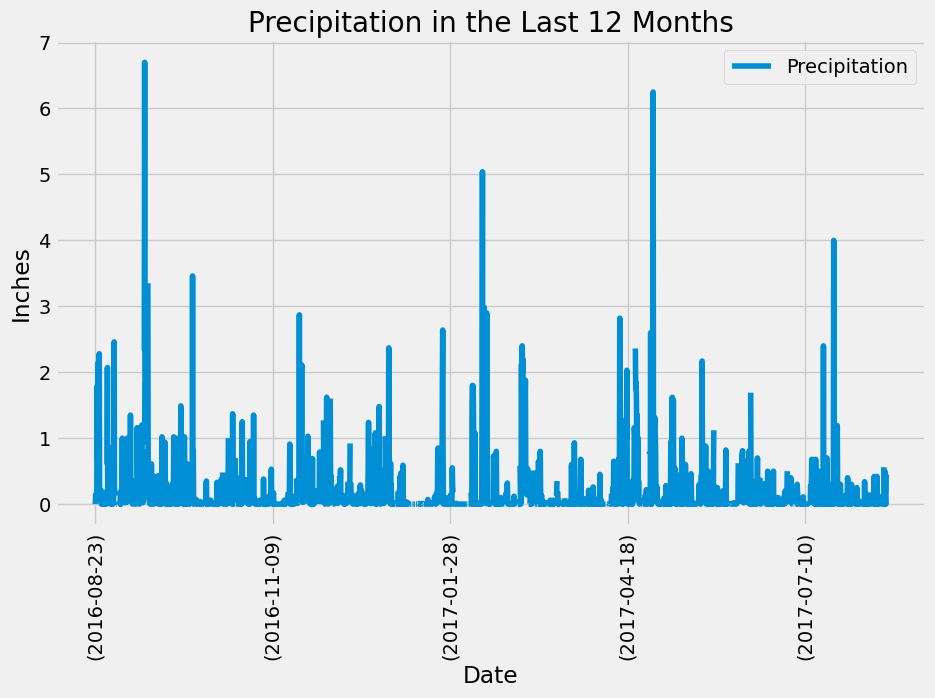

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
past_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", past_year)

# Perform a query to retrieve the date and precipitation scores
precip_data = session.query(measurement.prcp).\
    filter(measurement.date >= past_year).\
        order_by(measurement.date).all()

dates = session.query(measurement.date).\
    filter(measurement.date >= past_year).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results = {'Date': dates,
           'Precipitation': precip_data}

precip_df = pd.DataFrame(results)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='Date')

#Remove parentheses and commas 
precip_df['Precipitation'] = precip_df['Precipitation'].astype(str).str.replace(r"\(|\)", "", regex=True)
precip_df['Precipitation'] = precip_df['Precipitation'].astype(str).str.replace(r",", "", regex=True)

#convert to numeric type
precip_df['Precipitation'] = pd.to_numeric(precip_df['Precipitation'], errors='coerce')
precip_df 

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.set_index('Date', inplace=True)
precip_df.plot(figsize=(10, 6), title='Precipitation in the Last 12 Months', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats=precip_df['Precipitation'].describe()
summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
numstations = session.query(station).count()
print(numstations)

# Other method
station_count = session.query(func.count(func.distinct(station.station))).all()
station_count

9


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                            group_by(measurement.station).\
                            order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
most_active = active_stations[0][0]
most_active

'USC00519281'

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active).all()

temperature_stats

min_temp = temperature_stats[0][0]
max_temp = temperature_stats[0][1]
average_temp = temperature_stats[0][2]

print(f"Minimum temp: {min_temp} degrees")
print(f"Maximum temp: {max_temp} degrees")
print(f"Average temp: {round(average_temp, 2)} degrees")

Minimum temp: 54.0 degrees
Maximum temp: 85.0 degrees
Average temp: 71.66 degrees


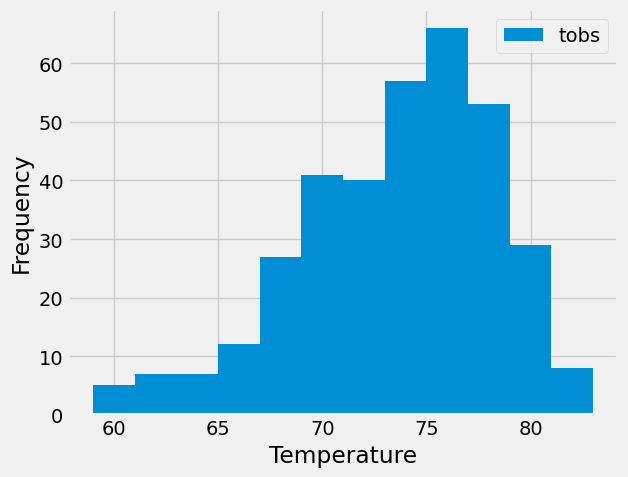

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= past_year).all()

temps_df = pd.DataFrame(temperature_data, columns=['tobs'])

plt.figure(figsize=(6.5,5))
plt.hist(temps_df['tobs'], bins=12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()